# Batch generator

In [17]:
import torch as t
from torch.utils import data
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from time import time

# ============================================================================
# Parameters
path_train = '/Users/cmiao/Cellari-Deeplearning-Course/train/cropped/raw'
path_anno = '/Users/cmiao/Cellari-Deeplearning-Course/train/cropped/anno'

batches = 30
crop_size = 256

# ============================================================================
# Functions to convert rgb segmaps to 2d

# Convert rgb array to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Mapping for grayscale original segmap
mapping = {
    0: 0,
    76: 1,
    149: 2,
    225: 3
}

# Mapping for grayscale imgaug segmap
mapping2 = {
    0: 0,
    91: 1,
    132: 2,
    211: 3
}

# Convert original segmap to 2d with classes
def create_anno(anno):
    anno_reshaped = rgb2gray(anno).astype(int)
    for k in mapping:
        anno_reshaped[anno_reshaped==k] = mapping[k]
    return anno_reshaped

# Convert imgaug segmap to 2d with classes
def seg_to_anno(seg):
    anno = rgb2gray(seg).astype(int)
    for k in mapping2:
        anno[anno==k] = mapping2[k]
    return anno

# ============================================================================
# Image Augmentors
seq = iaa.Sequential([
    iaa.HorizontalFlip(0.5),
    iaa.Affine(rotate=(-180, 180)),
    # iaa.Dropout(p=(0, 0.1)),
    # iaa.Sharpen((0.0, 1.0)),
    # iaa.ElasticTransformation(alpha=50, sigma=5),
    iaa.CropToFixedSize(width=crop_size, height=crop_size)
], random_order=False)

# Class to load + process data
class Custom_Data(data.Dataset):
    def __init__(self, path_train, path_anno):

        # Get all raw + annotated images
        raw_img = os.listdir(path_train)
        anno_img = os.listdir(path_anno)
        raw_img.sort()
        anno_img.sort()
        raw_imgs = [os.path.join(path_train, img) for img in raw_img]
        anno_imgs = [os.path.join(path_anno, img) for img in anno_img]

        # Select only images with at least 3 classes represented
        raw_new, anno_new = [], []
        thresh = 512 * 512 / 2
        for i in range(len(anno_imgs)):
            segmap = create_anno(np.array(Image.open(anno_imgs[i])))
            if (len(np.unique(segmap))>=3 and len(segmap[segmap == 0])<thresh):
                raw_new = np.append(np.append(raw_new, raw_imgs[i]), raw_imgs[i])
                anno_new = np.append(np.append(anno_new, anno_imgs[i]), anno_imgs[i])

        # print(len(raw_imgs), len(raw_new))
        self.raw_img = raw_new
        self.anno_img = anno_new

    def __getitem__(self, index, plots=False):

        # Get raw img + segmap at index
        raw_img_path = self.raw_img[index]
        raw_img = np.array(Image.open(raw_img_path))
        anno_img_path = self.anno_img[index]
        anno_img = np.array(Image.open(anno_img_path))

        # Format segmap
        anno_img = create_anno(anno_img).astype('int32')
        seg_map = SegmentationMapsOnImage(anno_img, shape=anno_img.shape)

        # print(raw_img_path, anno_img_path)

        # Perform data augmentations to generate 2 sets of augmented data
        raw_aug, seg_aug = seq(image=raw_img, segmentation_maps=seg_map)
        anno_aug = seg_aug.draw()[0]
        anno_aug = seg_to_anno(anno_aug)

        # Plot images to compare
        if plots:
            plt.figure()
            plt.subplot(2,2,1)
            plt.imshow(raw_img)
            plt.subplot(2,2,2)
            plt.imshow(anno_img)
            plt.subplot(2,2,3)
            plt.imshow(raw_aug)
            plt.subplot(2,2,4)
            plt.imshow(anno_aug)
            plt.show()

        return (raw_aug, anno_aug)

    def __len__(self):
        return len(self.raw_img)

# # ============================================================================
# Initialize
train_data = Custom_Data(path_train, path_anno)
train_loader = DataLoader(train_data, batch_size=batches, shuffle=True)

# SegNet

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Encode_conv_bn_x2(nn.Module):
    def __init__(self, in_, out):
        super(Encode_conv_bn_x2, self).__init__()
        
        self.relu    = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(out)
        self.conv2 = nn.Conv2d(out, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x    
    
class Encode_conv_bn_x3(nn.Module):
    def __init__(self, in_, out):
        super(Encode_conv_bn_x3, self).__init__()
        self.relu    = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(out)
        self.conv2 = nn.Conv2d(out, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(out)
        self.conv3 = nn.Conv2d(out, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x

class Dencode_conv_bn_x1(nn.Module):
    def __init__(self, in_, out):
        super(Dencode_conv_bn_x1, self).__init__()

        self.relu    = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, in_, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(in_)   
        self.conv2= nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        return x
    
class Dencode_conv_bn_x2(nn.Module):
    def __init__(self, in_, out):
        super(Dencode_conv_bn_x2, self).__init__()
  
        
        self.relu    = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, in_, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(in_)
        
        self.conv2= nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(out)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class Dencode_conv_bn_x3(nn.Module):
    def __init__(self, in_, out):
        super(Dencode_conv_bn_x3, self).__init__()

        
        self.relu    = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_, in_, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(in_)
        
        self.conv2 = nn.Conv2d(in_, in_, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(in_)
        
        self.conv3 = nn.Conv2d(in_, out, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(out)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        return x

class SegNet(nn.Module):
    def __init__(self,input_nbr = 3,label_nbr = 4):
        super(SegNet, self).__init__()
     
        
        self.encode1=Encode_conv_bn_x2(input_nbr,64)
        self.encode2=Encode_conv_bn_x2(64,128)
        self.encode3=Encode_conv_bn_x3(128,256)
        self.encode4=Encode_conv_bn_x3(256,512)
        self.encode5=Encode_conv_bn_x3(512,512)
        
        self.dencode5=Dencode_conv_bn_x3(512,512)
        self.dencode4=Dencode_conv_bn_x3(512,256)
        self.dencode3=Dencode_conv_bn_x2(256,128)
        self.dencode2=Dencode_conv_bn_x2(128,64)
        self.dencode1=Dencode_conv_bn_x1(64,label_nbr)
        
    def forward(self, x):
        # Stage 1
        x1=F.relu(self.encode1(x))
        self.x1p, self.id1 = F.max_pool2d(x1,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x2=F.relu(self.encode2(self.x1p))
        self.x2p, self.id2 = F.max_pool2d(x2,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x3=F.relu(self.encode3(self.x2p))
        self.x3p, self.id3 = F.max_pool2d(x3,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x4=F.relu(self.encode4(self.x3p))
        self.x4p, self.id4 = F.max_pool2d(x4,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x5=F.relu(self.encode5(self.x4p))
        self.x5p, self.id5 = F.max_pool2d(x5,kernel_size=2, stride=2,return_indices=True)
        
        # Stage 5d
        x5 = F.max_unpool2d(self.x5p, self.id5, kernel_size=2, stride=2)
        x5=F.relu(self.dencode5(x5))

        # Stage 4d
        x4= F.max_unpool2d(x5, self.id4, kernel_size=2, stride=2)
        x4=F.relu(self.dencode4(x4))
        
        
        # Stage 3d
        x3= F.max_unpool2d(x4, self.id3, kernel_size=2, stride=2)
        x3=F.relu(self.dencode3(x3))

        # Stage 2d
        x2= F.max_unpool2d(x3, self.id2, kernel_size=2, stride=2)
        x2=F.relu(self.dencode2(x2))

        # Stage 1d
        x1 = F.max_unpool2d(x2, self.id1, kernel_size=2, stride=2)
        x1=self.dencode1(x1)
        return x1

net = SegNet()

# from torchsummary import summary
# net = net.cuda()
# summary(net,(3, 256, 256), batch_size=5)

# Training

Running on CPU!
Start training!
Total training epoch: 3.
epoch = 1, loss: 4.0791120529174805
epoch = 2, loss: 3.812467575073242
epoch = 3, loss: 3.558300256729126
Finished Training


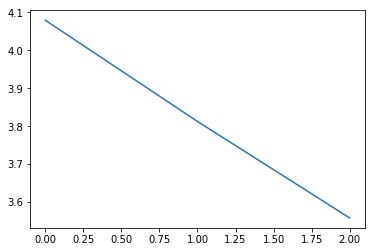

In [19]:
import torch
import torch.optim as optim
import torch.nn as nn

"""
# from median_frequency_weights import weight_class

should be a kind of improvment
"""

# weight_class = weight_class.astype(float)
# class_weights = torch.FloatTensor(weight_class)

# Initialize the net, loss, optimizer
use_cuda = torch.cuda.is_available()

if use_cuda:
    print("Running on GPU!")
    # class_weights = class_weights.cuda()
    net = net.cuda()
    # criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()
    criterion = nn.CrossEntropyLoss().cuda()
else:
    print("Running on CPU!")
    net = net
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

num_epoch = 3
print("Start training!")
print("Total training epochs: {}.".format(num_epoch))

net.train()
loss_curve = []
for epoch in range(0, num_epoch):
    training_loss = 0.0
    for i, data in enumerate(train_loader):

        inputs, targets = data
        inputs = inputs.permute(0,3,1,2)
        inputs = inputs.type(torch.FloatTensor)
        targets = targets.type(torch.LongTensor)
        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()
        # print("inpusts size = {}".format(inputs.size()))
        # print("targets size = {}".format(targets.size()))
        optimizer.zero_grad()
        
        # Forward pass
        outputs = net.forward(inputs)
        # print("outputs size = {}".format(outputs.size()))
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        training_loss = training_loss+loss.item()
        
        # Check the loss every 5 mini batches
        if (i%5 == 4):
            print("epoch = {},mini batch = {} loss: {}".format(epoch+1, i+1, loss.item()))
            
    # Check the loss every epoch
    print("epoch = {}, loss: {}".format(epoch+1, training_loss))
    loss_curve.append(training_loss)

print("Finished Training")
plt.plot(loss_curve)

# Testing

Running on GPU!
[  0  76 149 225]
%_class0 = 3.814697265625e-06
%_class1 = 0.9497909545898438
%_class2 = 0.049724578857421875
%_class3 = 0.00048065185546875


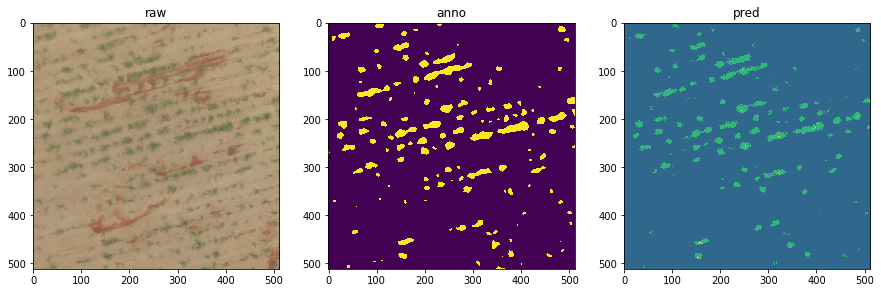

In [15]:
import torch
import os
import random
import glob
from PIL import Image
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt

net.eval()
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("Running on GPU!")
    net = net.cuda()

path_train = '/Users/cmiao/Cellari-Deeplearning-Course/test/cropped/raw'
path_anno = '/Users/cmiao/Cellari-Deeplearning-Course/test/cropped/anno'

img_list = glob.glob(path_to_images+os.sep+"*.png")
img_list = sorted(img_list)
anno_list = glob.glob(path_to_annotations+os.sep+"*.png")
anno_list = sorted(anno_list)

rand_int = random.randint(0, len(img_list))

raw_img = np.array(Image.open(img_list[rand_int]))
show_anno = np.array(Image.open(anno_list[rand_int]).convert("L"))

show_raw = raw_img

img = torch.from_numpy(raw_img).type(torch.FloatTensor).cuda()
img = img.permute(2,0,1)
# print(img.shape)

img = img.unsqueeze(0)

# print(img.shape)

pred = net(img)

# print(pred.shape)

pred = pred.squeeze()

pred_img = torch.argmax(pred, dim=0).cpu().numpy()

mapping_rev = {
    0:0,
    1:76,
    2:149,
    3:225
}
for item in mapping_rev:
    pred_img[pred_img==item] = mapping_rev[item]

print(np.unique(pred_img))

num_class0 = np.sum(pred_img==0)
num_class1 = np.sum(pred_img==76)
num_class2 = np.sum(pred_img==149)
num_class3 = np.sum(pred_img==225)
total = 512*512
print("%_class0 = {}".format(num_class0/total))
print("%_class1 = {}".format(num_class1/total))
print("%_class2 = {}".format(num_class2/total))
print("%_class3 = {}".format(num_class3/total))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(show_raw)
plt.title("raw")
# plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(show_anno)
plt.title("anno")
# plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(pred_img)
plt.title("pred")
# plt.colorbar()
plt.show()

In [22]:
import torch
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms as T
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class Custom_Data(data.Dataset):
    def __init__(self, path_test_input, path_test_target):
        input = os.listdir(path_test_input)
        self.input = sorted([os.path.join(path_test_input, a) for a in input])
        target = os.listdir(path_test_target)
        self.target = sorted([os.path.join(path_test_target, a) for a in target])
        self.mapping = {
            0:0,
            76:1,
            149:2,
            225:3
        }

    def mapping_to_class(self, target):
        for k in self.mapping:
            target[target==k] = self.mapping[k]
        return target

    def __getitem__(self, index):
        
        # test input data
        test_input_path = self.input[index]
        test_input = Image.open(test_input_path)
        test_input = T.ToTensor()(test_input)

        # test target data
        test_target_path = self.target[index]
        test_target = Image.open(test_target_path)
        test_target = T.ToTensor()(test_target)
        test_target_RGB = test_target

        # mapping target to class index
        test_target = T.ToPILImage()(test_target).convert("L")
        test_target_grey = torch.from_numpy(np.array(test_target))
        test_target = self.mapping_to_class(test_target_grey)
    
        return test_input, test_target, test_target_RGB, test_target_grey, test_input_path, test_target_path

    def __len__(self):
        return len(self.input)
    
path_test_input = '/Users/cmiao/Cellari-Deeplearning-Course/test/cropped/raw'
path_test_target = '/Users/cmiao/Cellari-Deeplearning-Course/test/cropped/anno'

num_batch = 2
test_data = Custom_Data(path_test_input, path_test_target)
test_loader = DataLoader(test_data, batch_size=num_batch, shuffle=True)
test_iter = iter(test_loader)
test_input, test_target, test_target_RGB, test_target_grey, test_input_path, test_target_path = test_iter.next()

print("image path of selected samples from batch_generator_test")
print(np.array(test_input_path).reshape(-1,1))
print(np.array(test_target_path).reshape(-1,1))

image path of selected samples from batch_generator_test
[['/Users/cmiao/Cellari-Deeplearning-Course/test/cropped/raw/1_9_raw.png']
 ['/Users/cmiao/Cellari-Deeplearning-Course/test/cropped/raw/9_9_raw.png']]
[['/Users/cmiao/Cellari-Deeplearning-Course/test/cropped/anno/1_9_anno.png']
 ['/Users/cmiao/Cellari-Deeplearning-Course/test/cropped/anno/9_9_anno.png']]
